# Common Voice Multiple Words - Modélisation avec SpeechNet

In [15]:
import os
import pandas as pd
import numpy as np
import librosa
import glob 
import matplotlib.pyplot as plt
import seaborn as sns
import re                          # Utilisation des regex
import librosa                     # for working with audio in python
import librosa.display             # for waveplots, spectograms, etc
import soundfile as sf             # for accessing file information
from IPython.display import Audio
import soundfile as sf
from pathlib import Path
import warnings
import shutil
import tensorflow as tf

import tqdm
from tqdm import tqdm
from pydub import AudioSegment
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

sns.set()
# tqdm().pandas()
warnings.filterwarnings('ignore')

# Constantes
SAMPLE_RATE = 16000        #  couvre la fréquence de la voix humaine
DT = 0.02

params = {
    'max_audio_length': 10,                                             # T_MAX : Durée max d'un fichie audio
    'alphabet': ' !"&\',-.01234:;\\abcdefghijklmnopqrstuvwxyz',
    'causal_convolutions': False,
    'stack_dilation_rates': [1, 3, 9, 27],
    'stacks': 6,
    'stack_kernel_size': 7,
    'stack_filters': 3*128,
    'sampling_rate': SAMPLE_RATE,
    #
    'n_fft': 160*8,
    'frame_step': 160*4,
    'lower_edge_hertz': 0,
    'upper_edge_hertz': 8000,
    'num_mel_bins': 160
}

In [16]:
def load_audio(audio_path):
    return librosa.load(audio_path, sr = SAMPLE_RATE)

def plot_audio(audio_data, fe):
    plt.plot(1/fe*np.arange(len(audio_data)),audio_data)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

def getAudioWithFeatures(foldername, size_ = None, copyfiles = False):
    audio_liste=[]
    audio_path =""
    audio=""
    # basic infos
    all_data = []
    all_text = []
    all_path =[]
    # features
    all_stft =[]
    all_mfccs =[]
    all_chroma =[]
    all_mel =[]
    all_contrast=[]
    all_tonnetz =[]
    
    df = pd.read_csv("datasets/" + foldername + '.csv', delimiter=',')
    df.dataframeName = foldername + '.csv'
    r = re.compile(r"/{0}[a-zA-Z0-9-.]+")
    
    if size_ == None:
        size_ = len(df)
    
    with tqdm(total=size_) as pbar:
        for index in (range(size_)):
            pbar.update(1)
            temp1 = df['filename'].iloc[index]        # ['cv-valid-train', 'sample-000000.mp3']
            temp2 = df['text'].iloc[index]
            #print(temp2)                             # cv-valid-train/sample-000000.mp3
            audio_liste = r.findall(temp1)
            audio =  audio_liste[1] 
            audio_path = "datasets/" + foldername + "/" + audio
            fname = Path(audio_path)
            if fname.exists() == True :
                # print(audio)
                X, sample_rate = librosa.load(audio_path, mono = True, sr = None)
                # Resampling at 16000 Hz
                SR = params['sampling_rate']
                X = librosa.resample(X, sample_rate, SR)
                # Downsampling
                #X = X[::3]
                
                # features                
                stft = np.abs(librosa.stft(X))
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
                #mfcc = librosa.feature.mfcc(X, sr=8000)
                chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
                mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
                contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
                tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
                
                all_data.append(X)
                all_text.append(temp2)
                all_path.append(audio_path)
                #
                all_stft.append(stft)
                all_mfccs.append(mfccs)
                all_chroma.append(chroma)
                all_mel.append(mel)
                all_contrast.append(contrast)
                all_tonnetz.append(tonnetz)
                #df.progress_apply(lambda x: pass) 
                
                # pour Daniel, afin de récuperer les fichiers MP3 correspondant à l'appel de la fonction
                if copyfiles == True :
                    os.makedirs("Daniel/" + foldername + "/", exist_ok=True)
                    shutil.copyfile(audio_path, "Daniel/"  + audio_path)
                
            else:
                print("Err fichier non présent: ", audio_path)
            
    return all_data, all_text, all_path, all_stft, all_mfccs, all_chroma, all_mel, all_contrast, all_tonnetz

def ProcessRawData(raw_data):
    T_max = params['max_audio_length']
    fe = SAMPLE_RATE
    size_ = len(raw_data)
    k = 0
    X_audio=[]
    with tqdm(total=size_) as pbar:
        for i in range(size_):
            pbar.update(1)
            k += 1
            data = raw_data[i]
            if len(data) >= T_max*fe: 
                # Shape invalid: truncate pour le coup
                data = data[:int(T_max*fe)]

            # After this transformation add zeroes to have the right shape
            else :
                data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])

            X_audio.append(data)
        
        return X_audio
        



In [17]:
def logMelSpectrogram(audio, params, fe):
    stfts = librosa.stft(audio,
                        n_fft = int(params['n_fft']*fe/SAMPLE_RATE),
                        hop_length = int(params["frame_step"]*fe/SAMPLE_RATE),
                        center = False
                        ).T
    power_spectrograms = np.real(stfts * np.conj(stfts))
    num_spectrogram_bins = power_spectrograms.shape[-1]
    linear_to_mel_weight_matrix = librosa.filters.mel(
                                sr=fe,
                                n_fft=int(params['n_fft']*fe/SAMPLE_RATE) + 1,
                                n_mels=params['num_mel_bins'],
                                fmin=params['lower_edge_hertz'],
                                fmax=params['upper_edge_hertz']
                    ).T
    mel_spectrograms = np.tensordot(
                power_spectrograms,
                linear_to_mel_weight_matrix,
                1
            )
    return (np.log(mel_spectrograms + 1e-6).astype(np.float16))


def plot_logMelSpectrogram(audio, params, fe):
    sns.heatmap(np.rot90(logMelSpectrogram(audio, params, fe)), cmap='inferno', xticklabels=False, yticklabels=False)

# Chargement des données

In [12]:
all_data, all_text, all_path, all_stft, all_mfccs, all_chroma, all_mel, all_contrast, all_tonnetz = getAudioWithFeatures("cv-valid-dev", 100)

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


# Preprocessing

In [13]:
all_data = ProcessRawData(all_data)

100%|██████████| 100/100 [00:00<00:00, 1275.85it/s]


### Features (X)

In [20]:
X_audio = np.array(all_data)
size_ = len(X_audio)
for i in range(size_):
    print(X_audio[i].shape)
X_audio.shape

(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)
(160000,)


(100, 160000)

In [21]:
# Mise en forme des fichiers audios
# X_audio est un tableau array de log mel spectrogramme dans la variable X.
fe = 16000
X = np.array([logMelSpectrogram(audio, params, fe) for audio in X_audio])
X.shape

(100, 249, 160)

### Target (Y)

In [23]:
df = pd.DataFrame(all_text,columns=['text'])
y = df.text
y.shape

(100,)

# Aperçu d'un fichier audio

### Signal audio

he moved about invisible but everyone could hear him


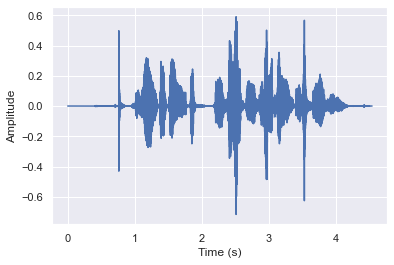

In [24]:
# raw data
path_to_file = all_path[4] # cv-valid-dev/sample-000004.mp3
audio,fe = load_audio(path_to_file);
print(all_text[4])
plot_audio(audio, fe)
Audio(audio, rate= fe)

[0. 0. 0. ... 0. 0. 0.]


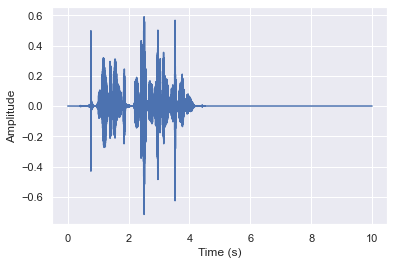

In [25]:
# processed data
print(X_audio[4])
plot_audio(X_audio[4], fe)
Audio(X_audio[4], rate= fe)

### Log du spectrogram dans l'echelle Mel

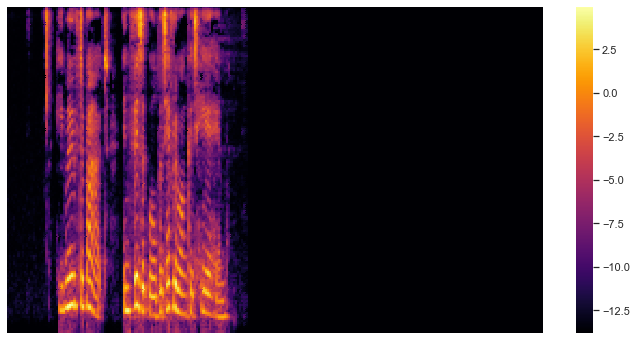

In [26]:
# raw data
plt.figure(figsize=(12,6))
plot_logMelSpectrogram(X_audio[4], params, fe)

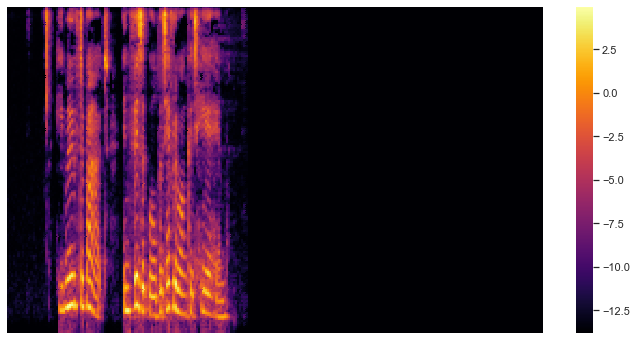

In [27]:
# Processed data
plt.figure(figsize=(12,6))
plot_logMelSpectrogram(X_audio[4], params, fe)

# Modélisation

### Chargement du modele SpeechNet

In [28]:
class AtrousConv1D(tf.keras.layers.Layer):
    def __init__(self,
                 filters,
                 kernel_size,
                 dilation_rate,
                 use_bias=True,
                 kernel_initializer=tf.keras.initializers.GlorotNormal(),
                 causal=True
                ):
        super(AtrousConv1D, self).__init__()
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.causal = causal
        
        # Convolution with dilation
        self.conv1d = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='valid' if causal else 'same',
            use_bias=use_bias,
            kernel_initializer=kernel_initializer
        )
        
    def call(self, inputs):
        # If padding 'valid', the shape of tensor change.
        if self.causal:
            padding = (self.kernel_size - 1) * self.dilation_rate
            inputs = tf.pad(inputs, tf.constant([(0, 0,), (1, 0), (0, 0)]) * padding)
        
        return self.conv1d(inputs)
    
    
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, causal, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        
        self.batch_normalization = tf.keras.layers.BatchNormalization()
        
        # First convolution of ResidualBloack
        self.dilated_conv1 = AtrousConv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            causal=causal
        )
        
        # Second convolution of ResidualBloack
        self.dilated_conv2 = AtrousConv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            causal=causal
        )
        
        self.out = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=1
        )
        
    def call(self, inputs, training=True):
        # Normalization of data
        data = self.batch_normalization(
            inputs
        )
        # Dilated convolution filters
        filters = self.dilated_conv1(data)
        filters = tf.nn.tanh(filters)
        
        # Dilated convolution gates
        gates = self.dilated_conv2(data) 
        gates = tf.nn.sigmoid(gates)
        
        # Elem-wise multiply
        out = tf.nn.tanh(
            self.out(
                filters * gates
            )
        )
        
        return out + inputs, out
    
        
class ResidualStack(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rates, causal, **kwargs):
        super(ResidualStack, self).__init__(**kwargs)
        
        # Definition of all Residual Block
        self.blocks = [
            ResidualBlock(
                filters=filters,
                kernel_size=kernel_size,
                dilation_rate=dilation_rate,
                causal=causal
            )
            for dilation_rate in dilation_rates
        ]
        
    def call(self, inputs, training=True):
        data = inputs
        skip = 0
        
        for block in self.blocks:
            # Output of Residual Block
            data, current_skip = block(data, training=training)
            # add all each skip connection
            skip += current_skip

        return skip


class SpeechNet(tf.keras.Model):
    def __init__(self, params, **kwargs):
        super(SpeechNet, self).__init__(**kwargs)
        
        self.batchnormalization1 =tf.keras.layers.BatchNormalization()
        
        # Expand convolution: extract features
        self.expand = tf.keras.layers.Conv1D(
            filters = params['stack_filters'],
            kernel_size=1,
            padding='same'
        )
        # Definition of all Residual Stack
        self.stacks = [
            ResidualStack(
                filters=params['stack_filters'],
                kernel_size=params['stack_kernel_size'],
                dilation_rates=params['stack_dilation_rates'],
                causal=params['causal_convolutions']
            )
            for _ in range(params['stacks'])
        ]
        # Definition of the last convolution
        self.out = tf.keras.layers.Conv1D(
            filters=len(params['alphabet']) + 1,
            kernel_size=1,
            padding='same'
        )
        
        self.batchnormalization2 = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs, training=True):
        # Data Normalization
        data = self.batchnormalization1(
            inputs
        )
        
        # Right shape for convolution.
        if len(data.shape) == 2:
            data = tf.expand_dims(data, 0)
            
        # Extract features    
        data = self.expand(data)
        
        # Residual Stack
        for stack in self.stacks:
            data = stack(data, training=training)
        
        # Data Normalization
        data = self.batchnormalization2(
            data
        )
        
        return self.out(data) + 1e-8

In [29]:
model = SpeechNet(params)
number_exploited_data = params['max_audio_length']*params['sampling_rate']-params['n_fft']
lengths = int(number_exploited_data/params['frame_step']+1)
model(np.random.uniform(size=[1, lengths, params['num_mel_bins']]))
model.load_weights('model/cv/cv_multiple.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Résultat

### Matrice de probabilté de X

In [15]:
y_logit = model(X)
y_logit

<tf.Tensor: shape=(100, 249, 43), dtype=float32, numpy=
array([[[ 2.7234285e+00, -6.7301649e-01,  5.3822100e-01, ...,
          1.2705168e-01, -1.1570891e-01,  1.4316008e+01],
        [ 4.4261560e+00, -1.2319568e+00,  1.1337265e+00, ...,
          5.6908029e-01, -2.8417921e+00,  1.5439016e+01],
        [ 6.4149718e+00, -1.4348408e+00,  1.1360407e+00, ...,
          1.0176851e+00, -3.1982408e+00,  1.5323566e+01],
        ...,
        [-1.2350898e+01, -5.4748452e-01,  1.8013959e+00, ...,
          7.6950517e+00, -3.0504358e-01, -4.3722206e+01],
        [-7.9859867e+00, -1.6875879e+00,  2.9411027e-02, ...,
          7.4353604e+00, -5.6968164e+00, -4.0328808e+01],
        [-7.7619371e+00, -1.1399704e+00,  1.4482157e+00, ...,
          6.7067103e+00, -4.6667771e+00, -3.8818165e+01]],

       [[-1.2479707e+01, -1.6862534e+01, -1.7703371e+01, ...,
         -1.4804260e+01, -1.5450090e+01, -7.5891557e+00],
        [-1.1728837e+01, -1.4709267e+01, -1.5687511e+01, ...,
         -1.1382390e+01, -1

### Beam search decoder de Tensorflow

In [16]:
def decode_codes(codes, charList):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)

def greedy_decoder(logits, params):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_beam_search_decoder(
        inputs = tf.transpose(logits, (1, 0, 2)),
        sequence_length = [logits.shape[1]]*logits.shape[0],
        beam_width = 100,
        top_paths = 1
    )
    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)
    
    # Decode the index of caracter
    text = decode_codes(codes, list(params['alphabet']))
    
    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)
    
    return list(map(lambda x: ''.join(x), text))

In [17]:
y_logit = model(X)
transcriptions = greedy_decoder(y_logit, params)
transcriptions

['be careful with your prognostications said the stranger semeytyse',
 'than h fie should hey be surplised when the seone wl wol on e e   e efesys',
 'a young arab also loaded downwith baggage entered and greited the englishmanru',
 "i thought that everything i owned would be destroyed semstyse'",
 "he oved about invisible but everyone could hear him   leetyse'",
 'but everything had changedincient as evenedt da icit e ys',
 'are you sure th gis is clair   s a ee t  esys',
 'it had told him to dig where his tears fell i ed  e ysys',
 'the shop folks were taking down their shutters and people were opening their bedroom windows s l rosm e',
 'the tere thought that had taughd himself or he wouldu',
 'the boy stepped closer to the girl when she smiled he ded the same  ec t e vieeys',
 "you haven't seen anything yeto o that ved  t esys",
 'but i found it difficult to get to work because of the investigationscnhiisneser gyse',
 'in those days very few of the people had any idea about astrono

In [18]:
sample_id = 4
print('Prediction :\n', transcriptions[sample_id], '\n')
print('Real Transcription :\n', y[sample_id])
Audio(X_audio[sample_id], rate=fe)

Prediction :
 he oved about invisible but everyone could hear him   leetyse' 

Real Transcription :
 he moved about invisible but everyone could hear him


# Test

In [19]:
#demo
def getSingleAudioFeatures(audio_path, size_ = 1, copyfiles = False):
    # basic infos
    all_data = []
    # features
    all_stft =[]
    with tqdm(total=size_) as pbar:
        for index in (range(size_)):
            pbar.update(1)
            fname = Path(audio_path)
            if fname.exists() == True :
                #print(audio_path)
                X, sample_rate = librosa.load(audio_path, mono = True, sr = None)
                # Resampling at 16000 Hz
                SR = params['sampling_rate']
                X = librosa.resample(X, sample_rate, SR)                
                # features                
                stft = np.abs(librosa.stft(X))
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
                #mfcc = librosa.feature.mfcc(X, sr=8000)
                all_data.append(X)
                all_stft.append(stft)                
                # pour Daniel, afin de récuperer les fichiers MP3 correspondant à l'appel de la fonction
                if copyfiles == True :
                    os.makedirs("Daniel/" + foldername + "/", exist_ok=True)
                    shutil.copyfile(audio_path, "Daniel/"  + audio_path)
            else:
                print("Err fichier non présent: ", audio_path)
    return all_data, all_stft 

In [20]:
# 1.load hello.mp3
audio, stft = getSingleAudioFeatures("TEST/hello.mp3")
audio = ProcessRawData(audio)

100%|██████████| 1/1 [00:00<00:00, 1567.38it/s]


In [21]:
X_audio = np.array(audio)
size_ = len(X_audio)
for i in range(size_):
    print(X_audio[i].shape)
X_audio.shape

# Mise en forme des fichiers audios X_audio sous la forme d'un tableau array de log mel spectrogramme dans la variable X.
fe = 16000
X = np.array([logMelSpectrogram(audio, params, fe) for audio in X_audio])
X.shape

(160000,)


(1, 249, 160)

[ 2.61141963e-06  1.15714683e-05 -5.61906245e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


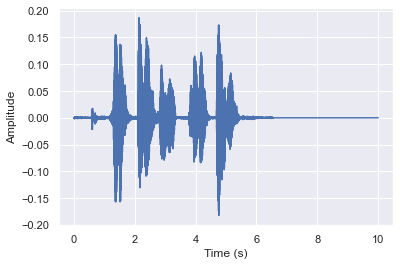

In [22]:
# 2.Processed data
# processed data
print(X_audio[0])
plot_audio(X_audio[0], fe)
Audio(X_audio[0], rate= fe)

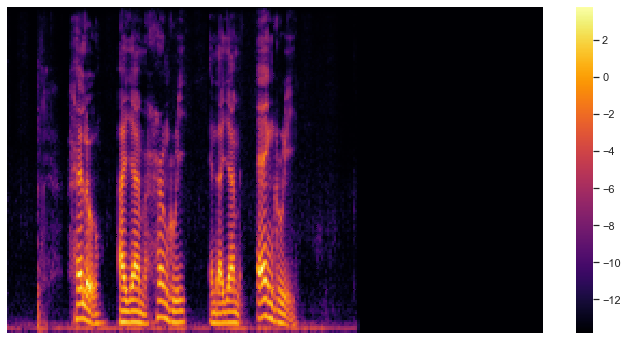

In [23]:
# 2.Processed data
plt.figure(figsize=(12,6))
plot_logMelSpectrogram(X_audio[0], params, fe)

In [24]:
y_logit = model(X)
y_logit

<tf.Tensor: shape=(1, 249, 43), dtype=float32, numpy=
array([[[  0.7938458 ,  -2.748781  ,  -1.0651083 , ...,  -0.50496954,
          -6.7127056 ,  16.382744  ],
        [ -0.7042653 ,  -3.5057526 ,  -2.099121  , ...,  -1.9396328 ,
          -6.911741  ,  15.131373  ],
        [ -2.3872497 ,  -5.662685  ,  -4.7064023 , ...,  -4.945948  ,
          -9.925438  ,  11.915258  ],
        ...,
        [-16.509874  ,   1.3045405 ,   3.0800054 , ...,   4.1795783 ,
           0.37386143, -51.10246   ],
        [-13.43597   ,  -1.1879956 ,   2.0291367 , ...,   5.9779205 ,
          -9.842633  , -46.11672   ],
        [-12.01221   ,  -0.94763935,   3.137354  , ...,   7.768193  ,
          -9.185426  , -41.670498  ]]], dtype=float32)>

In [25]:
transcriptions = greedy_decoder(y_logit, params)
transcriptions

["etsou a them wre hurgrly and tiy don't pangrey  t tofevetys"]